**Table of Content:**
* [Get Data](#1)
* [Popular Recommendation System](#2)
* [Memory Based - Collaborative Filtering](#3)
* [Model Based - Collaborative Filtering](#4)
* [Weighted Hybrid Recommendation System](#5)
* [Get Recommendation](#6)
* [Evaluation](#7)

If this notebook helped you, **Please Upvote**.


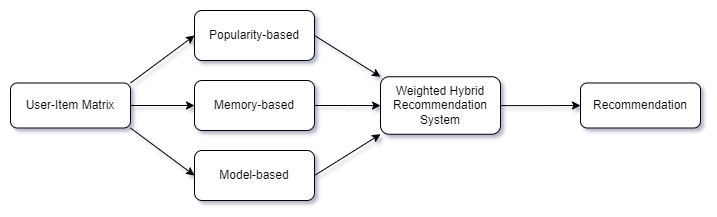

The goal of this project is to create a more effective recommendation system. This allows Santander bank to better meet the individual needs of all customers. To achieve this, the user-item matrix will be used containing the ID of consumers and the products they owned as of May 28, 2015. Then, recommendations in three different recommendation models will be calculated. It will be the popularity-based model, the memory-based collaborative filtering model, and the model-based collaborative filtering model. Then all three recommendations models will be combined into the weighted hybrid recommendation system. The result will be evaluated using average precision metrics.

In [1]:
import numpy as np 
import pandas as pd 
import random
from timeit import default_timer as timer

<a id="1"></a>
## Get Data
The dataset contains purchase data about the bank's customers and the bank's products.
The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit
card", "savings account", etc. 

In [2]:
dtype_list = {'ind_cco_fin_ult1': 'uint8', 'ind_deme_fin_ult1': 'uint8',
            'ind_aval_fin_ult1': 'uint8', 'ind_valo_fin_ult1': 'uint8',
            'ind_reca_fin_ult1': 'uint8', 'ind_ctju_fin_ult1': 'uint8',
            'ind_cder_fin_ult1': 'uint8', 'ind_plan_fin_ult1': 'uint8',
            'ind_fond_fin_ult1': 'uint8', 'ind_hip_fin_ult1': 'uint8',
            'ind_pres_fin_ult1': 'uint8', 'ind_nomina_ult1': 'Int64', 
            'ind_cno_fin_ult1': 'uint8', 'ind_ctpp_fin_ult1': 'uint8',
            'ind_ahor_fin_ult1': 'uint8', 'ind_dela_fin_ult1': 'uint8',
            'ind_ecue_fin_ult1': 'uint8', 'ind_nom_pens_ult1': 'Int64',
            'ind_recibo_ult1': 'uint8', 'ind_deco_fin_ult1': 'uint8',
            'ind_tjcr_fin_ult1': 'uint8', 'ind_ctop_fin_ult1': 'uint8',
            'ind_viv_fin_ult1': 'uint8', 'ind_ctma_fin_ult1': 'uint8',
            'ncodpers' : 'uint32'} 

In [3]:
name_col = ['ncodpers', 'fecha_dato', 'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1',
               'ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1',
               'ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1',
               'ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1',
               'ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

In [4]:
# alternative way to read large csv file
# df_train = pd.read_csv('../input/santander-product-recommendation/train_ver2.csv.zip', nrows=2e6,
#                      dtype=dtype_list, 
#                        usecols=name_col
#                     )

In [5]:
start = timer()
# read a large csv file using chunks with specified dtype and usecols parameters to optimize memory usage
reader = pd.read_csv('./df_train_small.csv.zip', chunksize=1e6,
                     dtype=dtype_list, usecols=name_col)

# concatenate the data from all the chunks into a single dataframe
df_train = pd.concat([chunk for chunk in reader])
df_train.shape

(13647309, 26)

In [6]:
# save a small version of the train set (50MB)
# df_train.to_csv('df_train_small.csv.zip', index=False,
#                 compression = {'method' : 'zip', 'archive_name' : 'df_train_small.csv'})

In [7]:
# data will be trained on '2015-05-28'
df_train1505 = df_train[df_train.fecha_dato == '2015-05-28']
df_train1505 = df_train1505.drop(['fecha_dato'], axis=1, inplace=False)
df_train1505 = df_train1505.fillna(0)
df_train1505.shape

(631957, 25)

<a id="2"></a>
## Popular Recommendation System

In [8]:
def popularity_based(df):
    """
    Function that calculates the probability of a product occurring. 
    Probability range is <0, 1>.
    """
    top_col = {}
    for col in df.columns[1:]:
        top_col[col] = df[col].value_counts()[1]
        
#     sorted by most popular
#     top_col = dict(sorted(top_col.items(), key=lambda it: it[1], reverse=True)) 
    
    for k, v in top_col.items():
        top_col[k] = np.around(v / df.shape[0], decimals=4)
        
    return top_col

In [9]:
popularity_based(df_train1505)

{'ind_ahor_fin_ult1': 0.0001,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.775,
 'ind_cder_fin_ult1': 0.0005,
 'ind_cno_fin_ult1': 0.1003,
 'ind_ctju_fin_ult1': 0.0121,
 'ind_ctma_fin_ult1': 0.0112,
 'ind_ctop_fin_ult1': 0.1661,
 'ind_ctpp_fin_ult1': 0.0562,
 'ind_deco_fin_ult1': 0.0033,
 'ind_deme_fin_ult1': 0.0023,
 'ind_dela_fin_ult1': 0.0556,
 'ind_ecue_fin_ult1': 0.1006,
 'ind_fond_fin_ult1': 0.0239,
 'ind_hip_fin_ult1': 0.0076,
 'ind_plan_fin_ult1': 0.0117,
 'ind_pres_fin_ult1': 0.0037,
 'ind_reca_fin_ult1': 0.0632,
 'ind_tjcr_fin_ult1': 0.0568,
 'ind_valo_fin_ult1': 0.0316,
 'ind_viv_fin_ult1': 0.005,
 'ind_nomina_ult1': 0.0655,
 'ind_nom_pens_ult1': 0.0672,
 'ind_recibo_ult1': 0.1527}

<a id="3"></a>
## Memory Based - Collaborative Filtering
Collaborative Filtering is based on the analysis of user ratings. In the dataset, the rating is information about the product ownership (1 or 0). In memory based technique recommendations are based on similarity between users. The similarity between users is calculated by the similarity measure function. It uses the cosine distance to create the user-item similarity matrix.



In [10]:
df_ui = df_train1505.copy()

df_ui = df_ui.set_index('ncodpers')
df_ui = df_ui[:10000] # limited to 10k due to RAM limit
df_ui.shape

(10000, 24)

In [11]:
from sklearn.metrics.pairwise import pairwise_distances 

# create the user-item similarity matrix
# removes index names
cosine_sim = 1 - pairwise_distances(df_ui, metric="cosine")

In [12]:
def useritem(user_id, df, sim_matrix = cosine_sim):
    """
    Function that calculates recommendations for a given user.
    It uses cosine similarity to calculate the most similar users.
    Returns the probability of products for a given user based on similar users.
    Probability range is <0, 1>.
    """
    # computes the index in the user-item similarity matrix for a given user_id
    cos_id = list(df.index).index(user_id) 
    
    # number of similar users
    k = 0
    sim_min = 0.79
    user_sim_k = {}
    
    while k < 20:
        # creates the dictionary {'similar user':'similarity'}
        for user in range(len(df)):
            
            # 0.99 because I don`t want the same user as user_id
            if sim_min < sim_matrix[cos_id, user] < 0.99:
                user_sim_k[user] = sim_matrix[cos_id, user]
                k+=1
                
        sim_min -= 0.025
        
        # if there are no users with similarity at least 0.65, the recommendation probability will be set to 0 
        if sim_min < 0.65:
            break
            
    # sorted k most similar users
    user_sim_k = dict(sorted(user_sim_k.items(), key=lambda item: item[1], reverse=True))
    user_id_k = list(user_sim_k.keys()) 
    
    # dataframe with k most similar users
    df_user_k = df.iloc[user_id_k]
    df_user_k_T = df_user_k.T
    
    # change the user index to the cosine index
    df_user_k_T.columns = user_id_k
    
    # mean of ownership by k similar users
    ownership = []
    usit = {}
    
    for row_name, row in df_user_k_T.iterrows():
        
        for indx, own in row.items():
            
            ownership.append(own) 
        
        usit[row_name] = np.mean(ownership)
        ownership = []
        
    # if there are no users with similarity at least 0.65, the recommendation probability is 0 
    if pd.isna(list(usit.values())[0]) == True:
        
        usit = {key : 0 for (key, value) in usit.items()}
            
    return usit

In [13]:
useritem(1061608, df_ui)

{'ind_ahor_fin_ult1': 0.0,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 1.0,
 'ind_cder_fin_ult1': 0.0,
 'ind_cno_fin_ult1': 0.0,
 'ind_ctju_fin_ult1': 0.0,
 'ind_ctma_fin_ult1': 0.00430416068866571,
 'ind_ctop_fin_ult1': 0.0,
 'ind_ctpp_fin_ult1': 0.0,
 'ind_deco_fin_ult1': 0.0,
 'ind_deme_fin_ult1': 0.0,
 'ind_dela_fin_ult1': 0.03156384505021521,
 'ind_ecue_fin_ult1': 0.31563845050215206,
 'ind_fond_fin_ult1': 0.00430416068866571,
 'ind_hip_fin_ult1': 0.0,
 'ind_plan_fin_ult1': 0.0,
 'ind_pres_fin_ult1': 0.0014347202295552368,
 'ind_reca_fin_ult1': 0.03443328550932568,
 'ind_tjcr_fin_ult1': 0.011477761836441894,
 'ind_valo_fin_ult1': 0.00860832137733142,
 'ind_viv_fin_ult1': 0.0,
 'ind_nomina_ult1': 0.0,
 'ind_nom_pens_ult1': 0.0,
 'ind_recibo_ult1': 0.5882352941176471}

<a id="4"></a>
## Model Based - Collaborative Filtering
Collaborative Filtering is based on the analysis of user ratings. In the dataset, the rating is information about the product ownership (1 or 0). In model based technique recommendations are based on machine learning models. The model is built on the matrix ownership of products by consumers.

In [14]:
df_mb = df_train1505.copy()
df_mb = df_mb.set_index('ncodpers')

In [15]:
df_val1603 = df_train[df_train.fecha_dato == '2016-03-28']
df_val1603 = df_val1603.drop(['fecha_dato'], axis=1, inplace=False)
df_val1603 = df_val1603.set_index('ncodpers')

In [16]:
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
def modelbased(user_id, df, model=DecisionTreeClassifier(max_depth=9)):
    """
    Function that calculates recommendations for a given user.
    It uses machine learning model to calculate the probability of products.
    Probability range is <0, 1>.   
    """
    
    mdbs = {}
    
    for c in df.columns:
        y_train = df[c].astype('int')
        x_train = df.drop([c], axis = 1)
        model.fit(x_train, y_train)
        p_train = model.predict_proba(x_train[x_train.index == user_id])[:,1]
        
        mdbs[c] = p_train[0]
        
    return mdbs

In [19]:
modelbased(1061608, df_mb)

{'ind_ahor_fin_ult1': 2.0143710989545413e-05,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.9354946617944848,
 'ind_cder_fin_ult1': 0.00019134466093726082,
 'ind_cno_fin_ult1': 0.00026302086100808724,
 'ind_ctju_fin_ult1': 3.0062710814759588e-06,
 'ind_ctma_fin_ult1': 0.006624955043928504,
 'ind_ctop_fin_ult1': 0.11178726596000622,
 'ind_ctpp_fin_ult1': 0.02026298551515136,
 'ind_deco_fin_ult1': 0.0026920204617169306,
 'ind_deme_fin_ult1': 0.0006220816686659199,
 'ind_dela_fin_ult1': 0.01911984941538546,
 'ind_ecue_fin_ult1': 0.03153603373338318,
 'ind_fond_fin_ult1': 0.004927893732809265,
 'ind_hip_fin_ult1': 0.00023275532427804286,
 'ind_plan_fin_ult1': 0.001406974657086115,
 'ind_pres_fin_ult1': 0.0016418788567050227,
 'ind_reca_fin_ult1': 0.009584422251260034,
 'ind_tjcr_fin_ult1': 0.005536443775532144,
 'ind_valo_fin_ult1': 0.008798761904495373,
 'ind_viv_fin_ult1': 0.0013513549041826276,
 'ind_nomina_ult1': 0.0,
 'ind_nom_pens_ult1': 1.1663412574558364e-05,
 'ind_recibo_ult1'

In [20]:
# # the model is generalized to the validation set (2016-03-28)
# param_grid_tree = {
#      'max_depth' : [5, 7, 9, 12]}

# grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=4, scoring='average_precision')

# for c in df_val1603.columns:
#     y_train = df_val1603[c].astype('int') 
#     x_train = df_val1603.drop([c], axis = 1)
#     grid_tree.fit(x_train, y_train)
        
# tree_clf_new = grid_tree.best_estimator_
# grid_tree.cv_results_
# # max_depth = 9 

<a id="5"></a>
## Weighted Hybrid Recommendation System
Hybrid recommender systems are based on a combination of individual recommender systems. This reduces the disadvantages of various types of systems, and thus increases the effectiveness of recommendations. One type of hybrid recommendation system is the weighted hybrid recommendation system. It works by combining all the results from individual recommendation systems using specific weightings.

In [21]:
def hybrid(user_id, df_p, df_u, df_m, f1, f2, f3):
    """
    Function that calculates weighted hybrid recommendations for a given user.
    It uses weights to calculate the probability of products. 
    """
    pb_h = popularity_based(df_p)
    ui_h = useritem(user_id, df_u)
    mb_h =  modelbased(user_id, df_m)

    hybrid = {}
    for k, v in pb_h.items():
        hybrid[k] = (v * f1) + (ui_h[k] * f2) + (mb_h[k] * f3)
    
    return hybrid

In [22]:
hybrid_rec_1061608 = hybrid(1061608, df_p = df_train1505, df_u = df_ui, df_m = df_mb, f1 = 0.5, f2 = 0.25, f3 = 0.25)
hybrid_rec_1061608

{'ind_ahor_fin_ult1': 5.503592774738636e-05,
 'ind_aval_fin_ult1': 0.0,
 'ind_cco_fin_ult1': 0.8713736654486212,
 'ind_cder_fin_ult1': 0.0002978361652343152,
 'ind_cno_fin_ult1': 0.050215755215252025,
 'ind_ctju_fin_ult1': 0.006050751567770369,
 'ind_ctma_fin_ult1': 0.008332278933148553,
 'ind_ctop_fin_ult1': 0.11099681649000155,
 'ind_ctpp_fin_ult1': 0.03316574637878784,
 'ind_deco_fin_ult1': 0.0023230051154292325,
 'ind_deme_fin_ult1': 0.0013055204171664799,
 'ind_dela_fin_ult1': 0.040470923616400166,
 'ind_ecue_fin_ult1': 0.1370936210588838,
 'ind_fond_fin_ult1': 0.014258013605368745,
 'ind_hip_fin_ult1': 0.0038581888310695108,
 'ind_plan_fin_ult1': 0.006201743664271529,
 'ind_pres_fin_ult1': 0.0026191497715650647,
 'ind_reca_fin_ult1': 0.04260442694014643,
 'ind_tjcr_fin_ult1': 0.03265355140299351,
 'ind_valo_fin_ult1': 0.0201517708204567,
 'ind_viv_fin_ult1': 0.002837838726045657,
 'ind_nomina_ult1': 0.03275,
 'ind_nom_pens_ult1': 0.033602915853143636,
 'ind_recibo_ult1': 0.239459

<a id="6"></a>
## Get Recommendation
Returns a list of recommendations for a given user.

In [23]:
product_names = {"ind_ahor_fin_ult1" : "Saving Account",
"ind_aval_fin_ult1" : "Guarantees",
"ind_cco_fin_ult1" : "Current Accounts",
"ind_cder_fin_ult1" : "Derivada Account",
"ind_cno_fin_ult1" : "Payroll Account",
"ind_ctju_fin_ult1" : "Junior Account",
"ind_ctma_fin_ult1" : "Más particular Account",
"ind_ctop_fin_ult1" : "particular Account",
"ind_ctpp_fin_ult1" : "particular Plus Account",
"ind_deco_fin_ult1" : "Short-term deposits",
"ind_deme_fin_ult1" : "Medium-term deposits",
"ind_dela_fin_ult1" : "Long-term deposits",
"ind_ecue_fin_ult1" : "e-account",
"ind_fond_fin_ult1" : "Funds",
"ind_hip_fin_ult1" : "Mortgage",
"ind_plan_fin_ult1" : "Pensions",
"ind_pres_fin_ult1" : "Loans",
"ind_reca_fin_ult1" : "Taxes",
"ind_tjcr_fin_ult1" : "Credit Card",
"ind_valo_fin_ult1" : "Securities",
"ind_viv_fin_ult1" : "Home Account",
"ind_nomina_ult1" : "Payroll",
"ind_nom_pens_ult1" : "Pensions",
"ind_recibo_ult1" : "Direct Debit"}

In [24]:
def change_names(col_names, map_products=product_names):
    '''
    Change column names (e.g."ind_recibo_ult1") to product names (e.g."Direct Debit").
    '''
    return list(map(lambda col_name: map_products[col_name], col_names))

In [25]:
def recommendation(user_id, df, hybrid_outcome):
    """
    Function that returns a list of recommendations for a given user.
    """
        
    # products that the user already owns
    user_row = df[df.index == user_id]
    user_products = list(filter(lambda product: user_row[product].to_numpy()[0]==1, user_row))
                
    # removes products that the user already owns
    recom = { key : hybrid_outcome[key] for key in hybrid_outcome if key not in user_products}

    recom_sort = dict(sorted(recom.items(), key=lambda item: item[1], reverse=True))
    
    return list(recom_sort.keys())

In [26]:
rec_1061608 = recommendation(1061608, df_mb, hybrid_rec_1061608)

In [27]:
change_names(rec_1061608)

['Direct Debit',
 'e-account',
 'particular Account',
 'Payroll Account',
 'Taxes',
 'Long-term deposits',
 'Pensions',
 'particular Plus Account',
 'Payroll',
 'Credit Card',
 'Securities',
 'Funds',
 'Más particular Account',
 'Pensions',
 'Junior Account',
 'Mortgage',
 'Home Account',
 'Loans',
 'Short-term deposits',
 'Medium-term deposits',
 'Derivada Account',
 'Saving Account',
 'Guarantees']

<a id="7"></a>
## Evaluation
In the evaluation, I use the average precision metric for 7 products. This metric checks the validity of the recommendations and the correctness of their position on the list of recommendations. The product with the highest probability of purchase is placed first in the list.

In [28]:
df_test1605 = df_train[df_train.fecha_dato == '2016-05-28']
df_test1605 = df_test1605.drop(['fecha_dato'], axis=1, inplace=False)

In [29]:
def rec_test(user_id, df1, df2):
    """
    Function that returns a list of test recommendations for a given user.
    """
    recom_test = []
    
    data_before = df1[df1.ncodpers == user_id].values[0]
    data_after = df2[df2.ncodpers == user_id].values[0]
    
    for i, col in enumerate(df1.columns[1:]):    
        if data_before[i+1] == 0 and data_after[i+1] == 1:
            recom_test.append(col)

    return recom_test

In [30]:
rec_test_1061608 = rec_test(1061608, df_train1505, df_test1605)

In [31]:
change_names(rec_test_1061608)

['Payroll Account', 'e-account', 'Payroll', 'Pensions', 'Direct Debit']

In [32]:
# referring to https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(actual, predicted, k=7):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=7):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [33]:
def evaluation(user_id, f1, f2, f3):
    """
    Function that returns the average precision metric for a given user.
    """
    y_real = rec_test(user_id, df_train1505, df_test1605)
    y_pred = recommendation(user_id, df_mb,
                            hybrid_outcome = hybrid(user_id, df_u = df_ui, df_m = df_mb,
                                                    df_p = df_train1505,
                                                    f1 = f1, f2 = f2, f3 = f3))
    return apk(y_real, y_pred)

In [34]:
evaluation(1061608, f1 = 0.8, f2=0.5, f3=0.2)

0.6642857142857143

In [35]:
end = timer()
print(round((end - start)/60 , 2),'min')

1.46 min


In [36]:
# # check best weight
# weight_val = []

# w = np.linspace(0.1,1,3)
# for i1 in w:
#     for i2 in w:
#         for i3 in w:
#             score = evaluation(1061608, f1 = i1, f2 = i2, f3 = i3)

#             weight_val.append([i1, i2, i3, score])

# weight_val = np.array(weight_val)

# # 0.8, 0.5, 0.2
# # 0.9, 0.3, 0.3
# weight_val